### --- Radiology Image Concepts Detection 

- Exploration
- Analysis
- Visualization
- Implementation of CNN in Keras to detect CUIS -- (Concept Unique Identifiers (CUI))

In [1]:
import os
import pandas as pd
import numpy as np
import re
from os import walk
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
import sys
import csv
import warnings
from sklearn.metrics import f1_score

import logging
import time
import math
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.layers import Dense
from keras.models import Model, load_model
from keras.preprocessing import image
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
##check if there is GPU -- Yes, in our case
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2679006077359297839,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4029477656267175874
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13353603127122147339
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11329617920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7216000314117401784
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

### --- Data Exploration

In [4]:
###know the current directory
os.getcwd()

'/home/ec2-user/SageMaker'

In [5]:
train_dir = 'roco-dataset/data/train/radiology/'
test_dir = 'roco-dataset/data/test/radiology/'
val_dir = 'roco-dataset/data/validation/radiology/'

In [6]:
##get the number of images in the images dir
train_img = os.listdir(train_dir + 'images')
val_img = os.listdir(val_dir + 'images')
test_img = os.listdir(test_dir + 'images')

In [7]:
##sort the list
train_img.sort()
val_img.sort()
test_img.sort()

In [8]:
train_img_size = len(train_img)
val_img_size = len(val_img)
test_img_size = len(test_img)

In [9]:
total_img_size = train_img_size + val_img_size + test_img_size

In [10]:
dataset = {'Dataset': ['Training data', 'Validation data', 'Test data', 'Total'], 'No of images': [train_img_size, val_img_size, 
                                                                                                   test_img_size, total_img_size]}
df_dataset = pd.DataFrame(dataset)

In [11]:
df_dataset

Dataset  No of images
0    Training data         60963
1  Validation data          7703
2        Test data          7662
3            Total         76328

In [12]:
df_train = pd.DataFrame(train_img, columns = ['image_name'])
df_val = pd.DataFrame(val_img, columns = ['image_name'])
df_test = pd.DataFrame(test_img, columns = ['image_name'])

In [13]:
df_train.head()

image_name
0  ROCO_00002.jpg
1  ROCO_00003.jpg
2  ROCO_00005.jpg
3  ROCO_00007.jpg
4  ROCO_00008.jpg

In [14]:
def create_df(data_dir, df):
    
    """
    This function creates dataframe with columns that includes: 
    captions, keywords, images names and CUIS
    """
    
    df_captions = pd.read_csv(data_dir + 'captions.txt', delimiter = '\t', header = None, names = [0, 'captions'])
    
    ##read in the cuis
    df_cuis = pd.read_fwf(data_dir + 'cuis.txt', header = None)
    cols = df_cuis.columns.tolist()[1:]
    df_cuis['concepts'] = df_cuis[cols].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)
    
    ##new df
    df_cuis = df_cuis.loc[:, [0, 'concepts']].copy()
    df_cuis['concepts'] = df_cuis['concepts'].apply(lambda x: re.sub(r'nan;|nan', '', x))
    
    ##read in the keywords
    df_words = pd.read_fwf(data_dir + 'keywords.txt', header = None)
    cols = df_words.columns.tolist()[1:]
    df_words['keywords'] = df_words[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
    
    ##new df
    df_words = df_words.loc[:, [0, 'keywords']].copy()
    df_words['keywords'] = df_words['keywords'].apply(lambda x: re.sub(r'\t', ';', x))
    df_words['keywords'] = df_words['keywords'].apply(lambda x: re.sub(r'nan', '', x))
    
    ###Lets Concatenate image_names, concepts, keywords, captions to one df
    df = pd.concat([df, df_captions, df_cuis, df_words], axis=1, join='inner')
    
    df.drop([0], axis = 1, inplace = True)
    return df

In [15]:
df_train = create_df(train_dir, df_train)

In [16]:
df_train.head()

image_name                                           captions  \
0  ROCO_00002.jpg   Computed tomography scan in axial view showin...   
1  ROCO_00003.jpg   Bacterial contamination occurred after comple...   
2  ROCO_00005.jpg   The patient had residual paralysis of the han...   
3  ROCO_00007.jpg      Panoramic radiograph after immediate loading.   
4  ROCO_00008.jpg   Plain abdomen x-ray: Multiple air levels at t...   

                                            concepts  \
0  C1293136;C0040395;C0024947;C0034579;C0004454;C...   
1  C0011121;C1533734;C0040426;C1318154;C1561542;C...   
2  C0043299;C1561577;C0918012;C1962945;C4283785;C...   
3      C0043299;C1306645;C1548003;C1962945;C1697779;   
4               C0042241;C0152097;C0011980;C0607422;   

                                            keywords  
0  scan;maxillary;sinu;axial;tomography;obliterat...  
1  canal;completion;temporary;month;filling;treat...  
2  poliomyeliti;index;healing;necessary;complete;...  
3             panoramic;loading;immediate;radiograph  
4  multiple;radiopaque;level;diaphragm;plain;air;...

In [17]:
df_train.shape

(60963, 4)

In [18]:
df_val = create_df(val_dir, df_val)

In [19]:
df_val.head()

image_name                                           captions  \
0  ROCO_00020.jpg   Axial computed tomography scan of the pelvis ...   
1  ROCO_00027.jpg   Postoperative anteroposterior radiograph of t...   
2  ROCO_00059.jpg   Angiography of the internal carotid artery, l...   
3  ROCO_00068.jpg   Case 4: (A) pretreatment radiograph; (B) Root...   
4  ROCO_00073.jpg   Preintervention MRCP revealing a nine-millime...   

                                            concepts  \
0  C4300092;C0040395;C1692321;C1704454;C0034579;C...   
1      C0043299;C1306645;C1548003;C0030797;C1962945;   
2  C0013103;C0741968;C0002978;C0771936;C0012621;C...   
3  C1306645;C1962945;C1548003;C0376495;C0043299;C...   
4  C0886296;C0184661;C0687028;C1837463;C0456824;C...   

                                            keywords  
0  pelvi;scan;wall;bladder;situ;axial;arrow;infil...  
1     postoperative;pelvi;radiograph;anteroposterior  
2  arterial;angiography;nidu;venou;drainage;late;...  
3  canal;case;apical;rootcanal;foramina;pretreatm...  
4  mrcp;stone;ninemillimeter;preintervention;duct...

In [20]:
df_val.shape

(7703, 4)

In [21]:
df_test = create_df(test_dir, df_test)

In [22]:
df_test.head()

image_name                                           captions  \
0  ROCO_00001.jpg                          Axial MRI (coronal view).   
1  ROCO_00006.jpg   Coronal plain computed tomography image showi...   
2  ROCO_00016.jpg   Axial source image from an intracranial magne...   
3  ROCO_00025.jpg   The apical height, homogeneity, and the thick...   
4  ROCO_00031.jpg            CTO of RCA (closure in the 2nd segment)   

                                            concepts  \
0                                                      
1  C0040395;C0011334;C1696103;C0027651;C0034579;C...   
2  C0449416;C1696103;C0741968;C0439775;C0002978;C...   
3                                          C0063825;   
4                                                      

                                            keywords  
0                             axial;coronal;mri;view  
1  tumor;abdominal;cavity;plain;image;edge;large;...  
2  arterial;reveal;sinus;magnetic;elevation;signa...  
3  plug;apical;thicknes;mineral;trioxide;homogene...  
4                            closure;cto;segment;rca

In [23]:
df_test.shape

(7662, 4)

### Analysis

In [24]:
##return distinct concepts with their number of counts
def concepts(df):
    concepts_list = []
    for concepts in df['concepts'].values.tolist():
        concepts = concepts.split(';')
        for item in concepts:
            if item:
                concepts_list.append(item)
    concept_dict = dict(Counter(concepts_list).most_common())
    return concept_dict

In [25]:
train_concepts_dict = concepts(df_train)
val_concepts_dict = concepts(df_val)
test_concepts_dict = concepts(df_test)

In [26]:
##number of distinct concepts in the training datasets
print(len(train_concepts_dict))

5678


In [27]:
##number of distinct concepts in the validation datasets
print(len(val_concepts_dict))

3150


In [28]:
##number of distinct concepts in the test datasets
print(len(test_concepts_dict))

3333


In [29]:
##Get the top concepts with the highest counts
def top_concepts(concept_dict, num):
    top_concepts = {}
    for idx, key in enumerate(concept_dict):
        #print(key, train_concepts[key])
        top_concepts[key] = concept_dict[key]
        if idx == num:
            break
    return top_concepts

In [30]:
##top 10
trn_top_10 = top_concepts(train_concepts_dict, 10)

In [31]:
print('Top 10 concepts in train dataset:')
for k in trn_top_10:
    print(k,trn_top_10[k])

Top 10 concepts in train dataset:
C0376152 11044
C1837463 11023
C1546708 11008
C0771936 10998
C0423899 10102
C0015726 10038
C1261259 9998
C1696103 9487
C0441633 7192
C1306645 6638
C0043299 6615


In [32]:
val_top_10 = top_concepts(val_concepts_dict, 10)

In [33]:
print('Top 10 concepts in validation dataset:')
for k in val_top_10:
    print(k,val_top_10[k])

Top 10 concepts in validation dataset:
C1837463 1411
C1546708 1398
C0771936 1390
C0376152 1333
C0423899 1275
C0015726 1268
C1261259 1224
C1696103 1136
C0441633 897
C0040395 826
C0043299 807


In [34]:
trn_distincts_concept_list = [key for key in train_concepts_dict]
val_distincts_concept_list = [key for key in val_concepts_dict]

In [35]:
##concepts present in the val data but not in the training data
concepts_abst = [x for x in val_distincts_concept_list if x not in trn_distincts_concept_list]

In [36]:
print('Number of validation concepts missing in the training data:', len(concepts_abst))

Number of validation concepts missing in the training data: 124


In [37]:
###for the frequency and concept distribution in the dataset we will concatenate the validation and train df
df_val_trn = pd.concat([df_train, df_val], ignore_index=True)

In [38]:
df_val_trn.shape

(68666, 4)

In [39]:
val_trn_concepts = concepts(df_val_trn)

In [40]:
data_top_10 = top_concepts(val_trn_concepts, 10)

In [41]:
print('Top 10 concepts in val + train dataset:')
for k in data_top_10:
    print(k,data_top_10[k])

Top 10 concepts in val + train dataset:
C1837463 12434
C1546708 12406
C0771936 12388
C0376152 12377
C0423899 11377
C0015726 11306
C1261259 11222
C1696103 10623
C0441633 8089
C1306645 7436
C0043299 7422


In [42]:
def concepts_distribution(data_dict):
    
    ##frequency range dict
    frequency_dict = {'1 - 3': None, '4 - 10': None, '11 - 50': None, '51 - 300': None, \
                      '301 - 1000': None, '1001 - 3000': None, '3001 - 5000':None, '5001 - 13000':None}
    
    ##grps
    grp_one = 0; grp_two = 0; grp_three = 0; grp_four = 0; grp_five = 0
    grp_six = 0; grp_seven = 0; grp_eight = 0
    
    for keys in data_dict:
        if data_dict[keys] >= 1 and data_dict[keys] <= 3:
            grp_one += 1
            frequency_dict['1 - 3'] = grp_one
        elif data_dict[keys] > 3 and data_dict[keys] <= 10:
            grp_two += 1
            frequency_dict['4 - 10'] = grp_two
        elif data_dict[keys] > 10 and data_dict[keys] <= 50:
            grp_three += 1
            frequency_dict['11 - 50'] = grp_three
        elif data_dict[keys] > 50 and data_dict[keys] <= 300:
            grp_four += 1
            frequency_dict['51 - 300'] = grp_four
        elif data_dict[keys] > 300 and data_dict[keys] <= 1000:
            grp_five += 1
            frequency_dict['301 - 1000'] = grp_five
        elif data_dict[keys] > 1000 and data_dict[keys] <= 3000:
            grp_six += 1
            frequency_dict['1001 - 3000'] = grp_six
        elif data_dict[keys] > 3000 and data_dict[keys] <= 5000:
            grp_seven += 1
            frequency_dict['3001 - 5000'] = grp_seven
        elif data_dict[keys] > 5000 and data_dict[keys] <= 13000:
            grp_eight += 1
            frequency_dict['5001 - 13000'] = grp_eight
            
    return frequency_dict

In [43]:
data_dist = concepts_distribution(val_trn_concepts)

In [44]:
data_dist

{'1 - 3': 2276,
 '4 - 10': 1178,
 '11 - 50': 1188,
 '51 - 300': 809,
 '301 - 1000': 252,
 '1001 - 3000': 73,
 '3001 - 5000': 6,
 '5001 - 13000': 20}

### --- Data Visualization

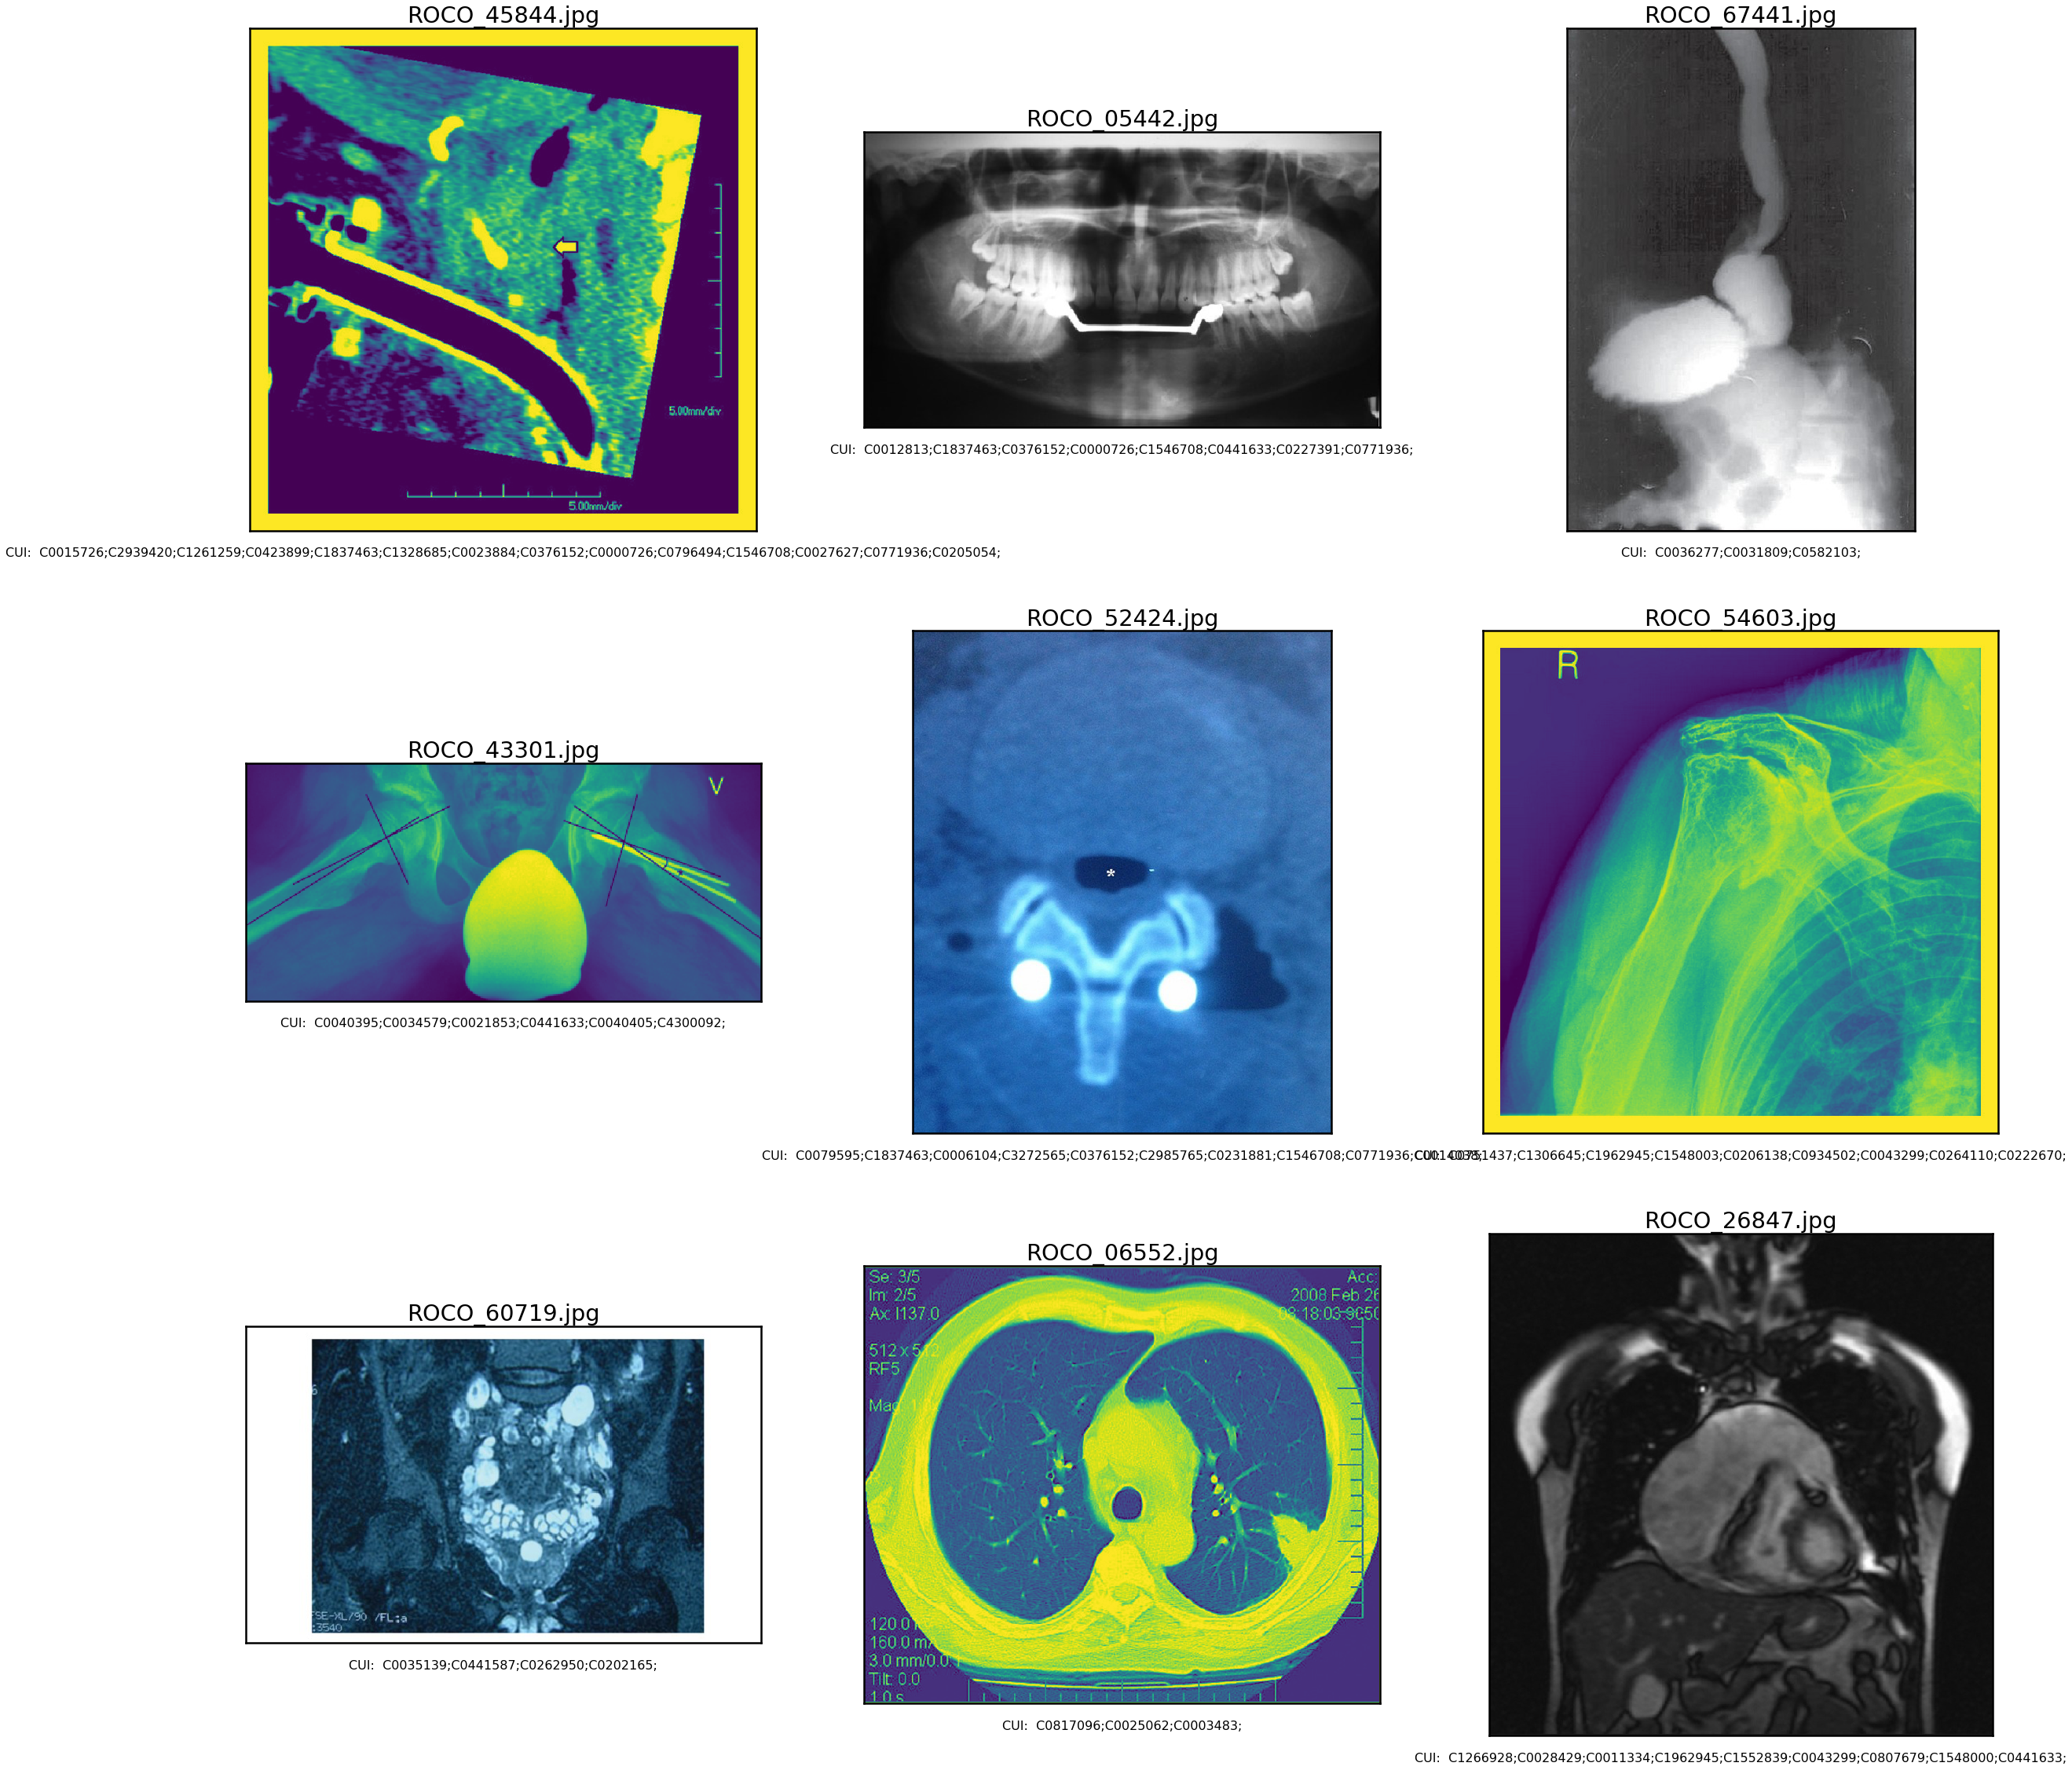

In [45]:
plt.figure(figsize=(40,40))
sns.set_context('poster', font_scale=1.2)
for i in range(9):
    x = random.randint(0, 60962) ## randomly select images from the train dataset
    sub = plt.subplot(3,3,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = Image.open(train_dir + 'images/' + df_train['image_name'][x])
    plt.imshow(img)
    plt.title(df_train['image_name'][x])
    plt.xlabel('\n'+'CUI:  '+ df_train['concepts'][x], fontsize = 16) ##add the CUI -- concepts for each image
    ##for the most part, the images overshadow the text written below them

Text(0.5, 1.0, 'Number of concepts versus frequency of their occurrence in the dataset')

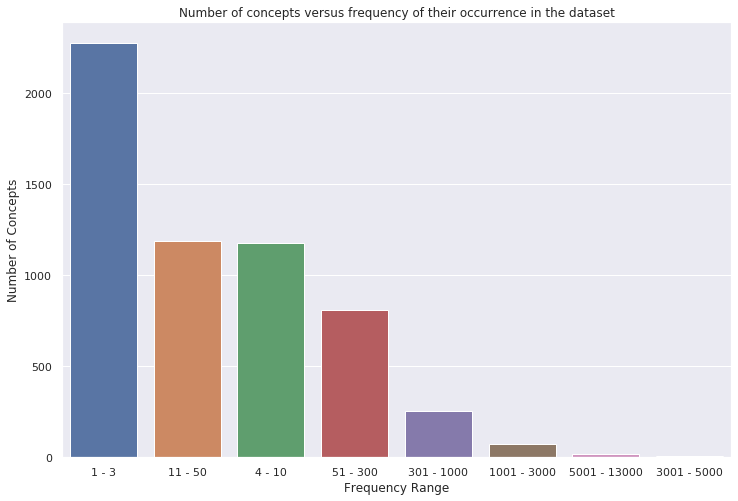

In [47]:
df_data = pd.DataFrame(data_dist.items(), columns = ['Frequency Range', 'Number of Concepts'])
df_data = df_data.sort_values(by='Number of Concepts', ascending = False)
plt.figure(figsize=(12,8))
sns.set_context('paper', font_scale = 0.85)
sns.set(style="darkgrid")
ax = sns.barplot(x="Frequency Range", y="Number of Concepts", data=df_data)
ax.set_title('Number of concepts versus frequency of their occurrence in the dataset')

Text(0.5, 1.0, 'Top 10 concepts based on their counts in the validation and training datasets')

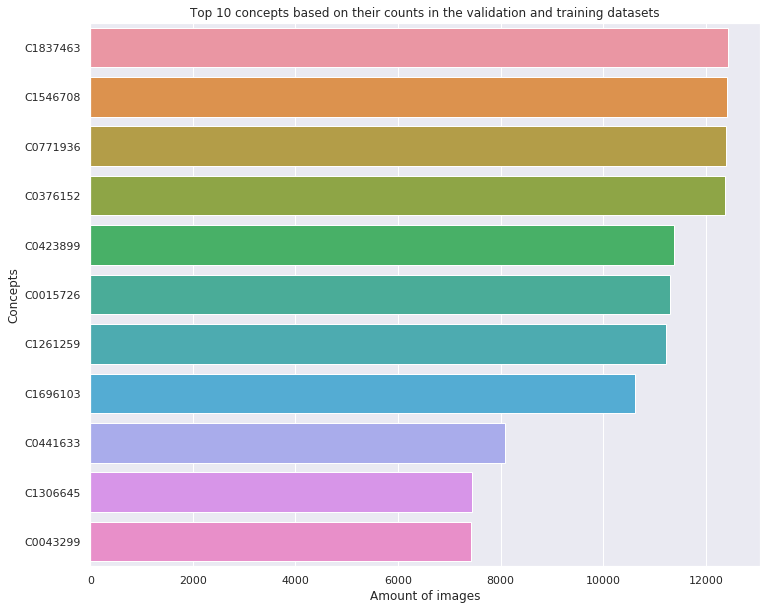

In [48]:
df_data = pd.DataFrame(data_top_10.items(), columns = ['Concepts', 'Amount of images'])
df_data = df_data.sort_values(by='Amount of images', ascending = False)
plt.figure(figsize=(12,10))
sns.set_context('paper', font_scale = 0.85)
sns.set(style="darkgrid")
ax = sns.barplot(x="Amount of images", y="Concepts", data=df_data)
ax.set_title('Top 10 concepts based on their counts in the validation and training datasets')

### ---- Implementation of CNN in Keras


- We are going to be using the entire concepts (i.e. validation and train data) for the multi-label classification

In [46]:
df_val_trn.shape

(68666, 4)

In [47]:
df_val_trn.loc[60963]

image_name                                       ROCO_00020.jpg
captions       Axial computed tomography scan of the pelvis ...
concepts      C4300092;C0040395;C1692321;C1704454;C0034579;C...
keywords      pelvi;scan;wall;bladder;situ;axial;arrow;infil...
Name: 60963, dtype: object

In [48]:
df_val.head(1)

image_name                                           captions  \
0  ROCO_00020.jpg   Axial computed tomography scan of the pelvis ...   

                                            concepts  \
0  C4300092;C0040395;C1692321;C1704454;C0034579;C...   

                                            keywords  
0  pelvi;scan;wall;bladder;situ;axial;arrow;infil...

In [49]:
df_train.tail(1)

image_name                                           captions  \
60962  ROCO_81823.jpg   Figure 6: A case of gastric perforation showi...   

                                                concepts  \
60962  C0151664;C0035361;C0032320;C1881710;C0019065;C...   

                                                keywords  
60962  figure;hollow;ga;thick;pneumoperitoneum;black;...

In [50]:
df_val_trn_concepts = df_val_trn[['image_name', 'concepts']].copy()
df_test_concepts = df_test[['image_name', 'concepts']].copy()

In [51]:
df_val_trn_concepts['concepts'] = df_val_trn_concepts['concepts'].str.split(';')
df_test_concepts['concepts'] = df_test_concepts['concepts'].str.split(';')

In [52]:
def remove_space(df):
    list_of_concepts = []
    for items in df['concepts']:
        concept_list = []
        for item in items:
            if item:
                concept_list.append(item)
        list_of_concepts.append(concept_list)
    return list_of_concepts

In [53]:
df_val_trn_concepts['concepts'] = remove_space(df_val_trn_concepts)
df_test_concepts['concepts'] = remove_space(df_test_concepts)

In [54]:
##create a new column "image_path" for both the df_train and df_val
df_val_trn_concepts['image_path'] = df_val_trn_concepts['image_name'].apply(lambda x:'images/' + x)
df_test_concepts['image_path'] = df_test_concepts['image_name'].apply(lambda x:'images/' + x)

In [55]:
df_val_trn_concepts.columns

Index(['image_name', 'concepts', 'image_path'], dtype='object')

In [56]:
df_val_trn_concepts.head()

image_name                                           concepts  \
0  ROCO_00002.jpg  [C1293136, C0040395, C0024947, C0034579, C0004...   
1  ROCO_00003.jpg  [C0011121, C1533734, C0040426, C1318154, C1561...   
2  ROCO_00005.jpg  [C0043299, C1561577, C0918012, C1962945, C4283...   
3  ROCO_00007.jpg  [C0043299, C1306645, C1548003, C1962945, C1697...   
4  ROCO_00008.jpg           [C0042241, C0152097, C0011980, C0607422]   

              image_path  
0  images/ROCO_00002.jpg  
1  images/ROCO_00003.jpg  
2  images/ROCO_00005.jpg  
3  images/ROCO_00007.jpg  
4  images/ROCO_00008.jpg

### - Data preprocessing 


--- https://keras.io/api/preprocessing/image/

- ImageDataGenerator -- Generate batches of tensor image data with real-time data augmentation.

- flow_from_dataframe -- Takes the dataframe and the path to a directory + generates batches. The generated batches contain augmented/normalized data.

- flow_from_directory -- Takes the path to a directory & generates batches of augmented data.

--- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

-- generate the full set of labels for each data sample in binarize format (0,1)

In [60]:
##augment the data by horizontal flip
## normalize the data scaling it down to btw 0 and 1 
##CREDITS: https://github.com/AntonisFaros/Image_Classification_IMAGECLEF2019/blob/master/ImageClef2019-Faros%20Antonios.ipynb
train_image_generator = ImageDataGenerator(rescale=1./255,horizontal_flip = True) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator=ImageDataGenerator(rescale=1./255.)# Generator for our testing data

In [57]:
##get the index as a column
##this will be needed to apply multilabel encoding
df_val_trn_concepts['index'] = df_val_trn_concepts.index
df_test_concepts['index'] = df_test_concepts.index

In [58]:
##train and validation datasets
df_train_concepts = df_val_trn_concepts.loc[0:60962]
df_val_concepts = df_val_trn_concepts.loc[60963:]

In [62]:
##image heights & width
img_height = 224
img_width = 224
batch_size = 32
##train_generator
train_data_gen = train_image_generator.flow_from_dataframe(dataframe= df_train_concepts,#we only get the training images
                                                           directory = train_dir,
                                                           x_col="image_path",
                                                           y_col="index",
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode = 'other')

Found 60963 validated image filenames.


In [63]:
##validation_generator
val_data_gen = val_image_generator.flow_from_dataframe(dataframe = df_val_concepts,
                                                             directory=val_dir,
                                                             x_col = "image_path",
                                                             y_col = "index",
                                                             shuffle = True,
                                                             batch_size=batch_size,
                                                             target_size=(img_height, img_width),
                                                             class_mode='other')

Found 7703 validated image filenames.


In [64]:
dev_image_generator = ImageDataGenerator(rescale = 1./255.)#Generator for the valiation evaluation

In [65]:
##validation dataset that will be used to tune the decision threshold to get the optimal F1 Score
dev_data_gen = dev_image_generator.flow_from_directory(directory=val_dir, 
                                                       shuffle = False, 
                                                       batch_size=batch_size,
                                                       target_size=(img_height, img_width), 
                                                       class_mode = None)

Found 7703 images belonging to 2 classes.


In [66]:
test_data_gen = test_image_generator.flow_from_directory(directory=test_dir, 
                                                       shuffle = False, 
                                                       batch_size=batch_size,
                                                       target_size=(img_height, img_width), 
                                                       class_mode = None)

Found 7662 images belonging to 2 classes.


In [67]:
##Transform the labels i.e. concepts into a Binary formats
mlb = MultiLabelBinarizer()
mlb.fit(df_val_trn_concepts['concepts'])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [68]:
num_of_labels = mlb.classes_

In [69]:
print(num_of_labels)

['C0000589' 'C0000723' 'C0000726' ... 'C4489466' 'C4505257' 'C4505346']


In [79]:
##validation + training data labels
print('Total number of labels:', len(num_of_labels))

Total number of labels: 5802


In [80]:
###CREDITS: https://github.com/AntonisFaros/Image_Classification_IMAGECLEF2019/blob/master/ImageClef2019-Faros%20Antonios.ipynb
## this helper function binarize the labels of each images 
##Each image has 5802 binarize concepts i.e. out of the 5802 concepts, if a concept is present in the image, the value = 1
##And if the concepts is not present, the value is 0
def multilabel_flow_from_dataframe(data_generator, mlb, df):
    while True:
        for x, y in data_generator:
            indices = y.astype(np.int).tolist()
            y_multilabel = mlb.transform(df.iloc[indices]['concepts'].values.tolist()) ##each image has 5802 labels/concepts in our case
            yield x, y_multilabel

In [81]:
##multilabel_generator -> x == images, y == total num of labels for each image; per Batch
multilabel_generator_train = multilabel_flow_from_dataframe(train_data_gen, mlb, df_train_concepts)

In [82]:
multilabel_generator_val = multilabel_flow_from_dataframe(val_data_gen, mlb, df_val_concepts)

### --- CheXNet-based, DenseNet-121 Encoder + FFFNN (AUEB NLP Group, 2019)

In [ ]:
#####<img src="files/anomaly.png" width="800" height="400">

In [83]:
##CREDITS: https://github.com/nlpaueb/bioCaption/blob/master/bioCaption/models/tagModels/chexnet.py
def chexnet_model(num_tags):
    my_init = glorot_uniform(seed=42)
    base_model = DenseNet121(weights='imagenet', include_top=True)
    x = base_model.get_layer("avg_pool").output
    concept_outputs = Dense(num_tags, activation="sigmoid",
                            name="concept_outputs", kernel_initializer=my_init)(x)
    model = Model(inputs=base_model.input, outputs=concept_outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
    return model

In [84]:
chexnet_model = chexnet_model(len(num_of_labels))

In [74]:
##chexnet_model.summary()

In [76]:
os.listdir()

['.ipynb_checkpoints',
 'lost+found',
 'print_dir.py',
 'roco-dataset',
 '.sparkmagic',
 'untitled1.txt',
 'concept_detection.ipynb',
 'untitled.txt',
 'image_extraction_from_tarfiles.ipynb',
 'model',
 'extract_images.py']

In [86]:

epochs = 10

##Early Stopping -- Stop training when the validation loss is no more reducing after waiting for 3 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=3,
                                       mode="auto", restore_best_weights=True)

# save best model
checkpoint = ModelCheckpoint(os.path.join('/home/ec2-user/SageMaker/model', "chexnet_checkpoint.hdf5"), 
                             monitor="val_loss", save_best_only=True, mode="auto")

##Reduce Learning rate -- Reduce learning rate when the validation loss stop reducing by a factor of 0.1
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode="min")

# train the model
chexnet_history = chexnet_model.fit(multilabel_generator_train, 
                                    steps_per_epoch= math.ceil(df_train_concepts.shape[0] / batch_size), 
                                    epochs=epochs, callbacks=[early_stopping, checkpoint, reduce_lr], 
                                    validation_data= multilabel_generator_train, validation_steps= math.ceil(df_val_concepts.shape[0] / batch_size),
                                    workers = 4, use_multiprocessing=True)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
1906/1906 [==============================] - 3055s 2s/step - loss: 0.0080 - binary_accuracy: 0.9985 - val_loss: 0.0080 - val_binary_accuracy: 0.9985
Epoch 2/10
1906/1906 [==============================] - 3140s 2s/step - loss: 0.0079 - binary_accuracy: 0.9985 - val_loss: 0.0080 - val_binary_accuracy: 0.9985

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/10
1906/1906 [==============================] - 3032s 2s/step - loss: 0.0078 - binary_accuracy: 0.9985 - val_loss: 0.0071 - val_binary_accuracy: 0.9985
Epoch 4/10
1906/1906 [==============================] - 3170s 2s/step - loss: 0.0077 - binary_accuracy: 0.9985 - val_loss: 0.0085 - val_binary_accuracy: 0.9985

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/10
1906/1906 [==============================] - 3109s 2s/step - loss: 0.0077 - binary_accuracy: 0.9985 - val_loss: 0.0088 - val_binary_accuracy: 0.9985

Epoch 00005: ReduceLROnPlateau redu

In [87]:
def get_predictions(model_path, generator_data):
    
    chexnet_model = load_model(model_path)
    predictions = chexnet_model.predict(generator_data)
    return predictions

In [98]:
def results_groundtruth_data(predictions, data_dir, decision_threshold):
    
    #validation images
    val_images = os.listdir(data_dir + 'images')
    df_val_images = pd.DataFrame(val_images, columns = ['image_name'])
    
    ##get the predicted results/concepts with their corresponding validation images
    val_results = {}
    for i in range(len(predictions)):
        concepts_pred = []
        for j in range(len(mlb.classes_)):
            if predictions[i, j] >= decision_threshold:
                concepts_pred.append(mlb.classes_[j])
        val_results[val_images[i]] = ";".join(concepts_pred)
        
    ##read in the cuis (concepts) for the validation set
    df_cuis = pd.read_fwf(data_dir + 'cuis.txt', header = None)
    cols = df_cuis.columns.tolist()[1:]
    df_cuis['concepts'] = df_cuis[cols].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)
    
    ##new df_cuis
    df_cuis = df_cuis.loc[:, [0, 'concepts']].copy()
    df_cuis['concepts'] = df_cuis['concepts'].apply(lambda x: re.sub(r'nan;|;nan|nan', '', x))
    
    ###Lets Concatenate validate_images and cuis df to one df
    df_gd_val = pd.concat([df_val_images, df_cuis], axis=1, join='inner')
    df_gd_val.drop([0], axis = 1, inplace = True)
    
    ##get the groundtruth concepts with their corresponding images
    val_groundtruth = {}
    for x in range(df_gd_val.shape[0]):
        val_groundtruth[df_gd_val['image_name'][x]] = df_gd_val['concepts'][x]
    
    return val_groundtruth, val_results

In [92]:
dev_predictions = get_predictions('/home/ec2-user/SageMaker/model/chexnet_checkpoint.hdf5', dev_data_gen)

In [93]:
dev_predictions.shape

(7703, 5802)

In [59]:
##-- ImageCLEF 2019 F1 Evaluation Function (Remodified)
##I commented out all the print statetments
def calculate_f1(candidate_pairs, gt_pairs):

    # Hide warnings
    warnings.filterwarnings('ignore')

    # Concept stats
    min_concepts = sys.maxsize
    max_concepts = 0
    total_concepts = 0
    concepts_distrib = {}

    # Read files
    #print('Input parameters\n********************************')

    # Define max score and current score
    max_score = len(gt_pairs)
    current_score = 0

    # Check there are the same number of pairs between candidate and ground truth
    if len(candidate_pairs) != len(gt_pairs):
        print('ERROR : Candidate does not contain the same number of entries as the ground truth!')
        exit(1)

    # Evaluate each candidate concept list against the ground truth
    #print('Processing concept sets...\n********************************')

    i = 0
    for image_key in candidate_pairs:

        # Get candidate and GT concepts
        candidate_concepts = candidate_pairs[image_key].upper()
        gt_concepts = gt_pairs[image_key].upper()

        # Split concept string into concept array
        # Manage empty concept lists
        if gt_concepts.strip() == '':
            gt_concepts = []
        else:
            gt_concepts = gt_concepts.split(';')

        if candidate_concepts.strip() == '':
            candidate_concepts = []
        else:
            candidate_concepts = candidate_concepts.split(';')

        # Manage empty GT concepts (ignore in evaluation)
        if len(gt_concepts) == 0:
            max_score -= 1
        # Normal evaluation
        else:
            # Concepts stats
            total_concepts += len(gt_concepts)

            # Global set of concepts
            all_concepts = sorted(list(set(gt_concepts + candidate_concepts)))

            # Calculate F1 score for the current concepts
            y_true = [int(concept in gt_concepts) for concept in all_concepts]
            y_pred = [int(concept in candidate_concepts) for concept in all_concepts]

            f1score = f1_score(y_true, y_pred, average='binary')

            # Increase calculated score
            current_score += f1score

        # Concepts stats
        nb_concepts = str(len(gt_concepts))
        if nb_concepts not in concepts_distrib:
            concepts_distrib[nb_concepts] = 1
        else:
            concepts_distrib[nb_concepts] += 1

        if len(gt_concepts) > max_concepts:
            max_concepts = len(gt_concepts)

        if len(gt_concepts) < min_concepts:
            min_concepts = len(gt_concepts)

        # Progress display
        # i += 1
        # if i % 1000 == 0:
        #     print(i, '/', len(gt_pairs), ' concept sets processed...')
    
    # Print 1-level key-value dictionary, sorted (with numeric key)
    def print_dict_sorted_num(obj):
        keylist = [int(x) for x in list(obj.keys())]
        keylist.sort()
        for key in keylist:
            print(key, ':', obj[str(key)])

    ###Print stats
    # print('Concept statistics\n********************************')
    # print('Number of concepts distribution')
    # print_dict_sorted_num(concepts_distrib)
    # print('Least concepts in set :', min_concepts)
    # print('Most concepts in set :', max_concepts)
    # print('Average concepts in set :', total_concepts / len(candidate_pairs))

    # # Print evaluation result
    # print('Final result\n********************************')
    # print('Obtained score :', current_score, '/', max_score)
    # print('Mean f1 score over all concept sets :', current_score / max_score)

    mean_f1 = current_score / max_score

    return mean_f1

In [97]:
#lets calculate the f1 scores on different "Decision Threshold" values and see which one has the highest f1 score
##based on previous papers on imageclef 2019, let calculate f1 for the threshold btw 0.1 and 0.21
threshold_dict = {}
for x in np.arange(0.1, 0.21, 0.01):
    val_gt, val_candidate = results_groundtruth_data(dev_predictions, val_dir, decision_threshold = x)
    threshold_f1score = calculate_f1(val_candidate, val_gt)
    threshold_dict[x] = threshold_f1score

In [99]:
df_thres_f1 = pd.DataFrame(threshold_dict.items(), columns = ['Threshold values', 'f1 score'])
df_thres_f1

Threshold values  f1 score
0               0.10  0.157803
1               0.11  0.149425
2               0.12  0.143530
3               0.13  0.143374
4               0.14  0.143367
5               0.15  0.142649
6               0.16  0.131284
7               0.17  0.102978
8               0.18  0.094156
9               0.19  0.074709
10              0.20  0.005364

Text(0.5, 1.0, 'F1 score based on decision threshold values')

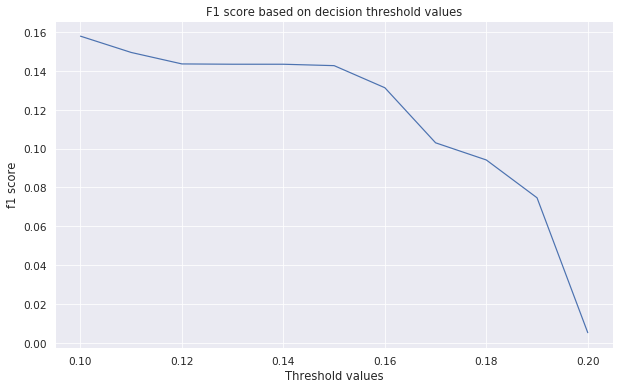

In [100]:
##plot f1 score for each "Decision Threshold"
plt.figure(figsize=(10,6))
sns.set_context('paper', font_scale = 1.2)
ax = sns.lineplot(x="Threshold values", y="f1 score", data=df_thres_f1)
ax.set_title('F1 score based on decision threshold values')

In [101]:
test_predictions = get_predictions('/home/ec2-user/SageMaker/model/chexnet_checkpoint.hdf5', test_data_gen)

In [102]:
test_gt, test_candidate = results_groundtruth_data(test_predictions, test_dir, decision_threshold = 0.10)
test_f1score = calculate_f1(test_candidate, test_gt)

In [103]:
print(test_f1score)

0.15635582902888057


### --- DenseNet-121 Encoder + k-NN Image Retrieval (AUEB NLP Group, 2019)

### CREDITS: [aeub_nlp_knn](https://github.com/nlpaueb/bioCaption/blob/master/bioCaption/models/tagModels/knn.py)

In [60]:
df_train_concepts.head(10)

image_name                                           concepts  \
0  ROCO_00002.jpg  [C1293136, C0040395, C0024947, C0034579, C0004...   
1  ROCO_00003.jpg  [C0011121, C1533734, C0040426, C1318154, C1561...   
2  ROCO_00005.jpg  [C0043299, C1561577, C0918012, C1962945, C4283...   
3  ROCO_00007.jpg  [C0043299, C1306645, C1548003, C1962945, C1697...   
4  ROCO_00008.jpg           [C0042241, C0152097, C0011980, C0607422]   
5  ROCO_00010.jpg  [C1547226, C0309093, C1696103, C4049705, C0230...   
6  ROCO_00011.jpg                     [C1963113, C0016658, C0262950]   
7  ROCO_00012.jpg  [C0021156, C0009429, C1318154, C0004454, C0376...   
8  ROCO_00014.jpg                     [C0040018, C1550517, C0087086]   
9  ROCO_00017.jpg  [C0013687, C0308269, C1696103, C1507248, C1546...   

              image_path  index  
0  images/ROCO_00002.jpg      0  
1  images/ROCO_00003.jpg      1  
2  images/ROCO_00005.jpg      2  
3  images/ROCO_00007.jpg      3  
4  images/ROCO_00008.jpg      4  
5  images/ROCO_00010.jpg      5  
6  images/ROCO_00011.jpg      6  
7  images/ROCO_00012.jpg      7  
8  images/ROCO_00014.jpg      8  
9  images/ROCO_00017.jpg      9

In [61]:
##train_dict with image_name as key, and concepts as value
train_dict = {key:value for (key,value) in zip(df_train_concepts['image_name'], df_train_concepts['concepts'])}

In [62]:
def create_dict(data_dir):
    
    val_images = os.listdir(data_dir + 'images')
    df_val_images = pd.DataFrame(val_images, columns = ['image_name'])
    ##read in the cuis (concepts) for the validation set
    df_cuis = pd.read_fwf(data_dir + 'cuis.txt', header = None)
    cols = df_cuis.columns.tolist()[1:]
    df_cuis['concepts'] = df_cuis[cols].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)
    
    ##new df_cuis
    df_cuis = df_cuis.loc[:, [0, 'concepts']].copy()
    df_cuis['concepts'] = df_cuis['concepts'].apply(lambda x: re.sub(r'nan;|;nan|nan', '', x))
    
    ###Lets Concatenate validate_images and cuis df to one df
    df_gd_val = pd.concat([df_val_images, df_cuis], axis=1, join='inner')
    df_gd_val.drop([0], axis = 1, inplace = True)
    
    ##get the groundtruth concepts with their corresponding images
    val_groundtruth = {}
    for x in range(df_gd_val.shape[0]):
        val_groundtruth[df_gd_val['image_name'][x]] = df_gd_val['concepts'][x]
    
    return val_groundtruth

In [63]:
##create dictionary: Key--image_names, value--concepts
val_dict = create_dict(val_dir)
test_dict = create_dict(test_dir)

In [64]:
def compute_image_embedding(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_vec= image.img_to_array(img)
    img_vec = np.expand_dims(img_vec, axis=0)
    img_vec = preprocess_input(img_vec)
    return img_vec

In [65]:
def knn(df, df2, train_dir, val_dir):
    
    """
    Returns image_similarities for the validation data based on train vecs, a list of training image names, 
    and normalized image embeddings/dense vector encodings of the training images
    """
    
    base_model = DenseNet121(weights='imagenet', include_top=True)
    vector_extraction_model = Model(inputs=base_model.input, outputs=base_model.get_layer("avg_pool").output)
    print("Calculating visual embeddings from train images")
    train_images_vec = {}
    print("Extracting image embeddings (Dense vector encoding) for all train images...")
    for train_image in tqdm(df['image_name']):
        image_path = os.path.join(train_dir + 'images/', train_image)
        x = compute_image_embedding(image_path)
        vec = vector_extraction_model.predict(x).transpose().flatten()
        train_images_vec[train_image] = vec
        #print("Got embeddings for train images.")
        
    # save image_name and raw image vectors seperately but aligned
    image_name = [i for i in train_images_vec]
    image_vectors = np.array([train_images_vec[i] for i in train_images_vec])
    # normalize image vectors to avoid normalized cosine and use dot
    image_vectors = image_vectors / np.array([np.sum(image_vectors, 1)] * image_vectors.shape[1]).transpose()
    
    # measure the similarity of each val image embedding with all train image embeddings
    images_similarity = {}
    for val_image in tqdm(df2['image_name']):
        image_path = os.path.join(val_dir + 'images/', val_image)
        x = compute_image_embedding(image_path)
        vec = vector_extraction_model.predict(x).transpose().flatten()
        vec = vec / np.sum(vec)
        # clone to do efficient mat mul dot
        test_mat = np.array([vec] * image_vectors.shape[0])
        sims = np.sum(test_mat * image_vectors, 1)
        # save the similarities array for every test image
        ##the no of cosine similarities per val image correspond to the nos of training images
        images_similarity[val_image] = sims
    return images_similarity, image_name, image_vectors

In [ ]:
img_sims, img_names, img_vects = knn(df_train, df_val, train_dir, val_dir)

33193984/33188688 [==============================] - 2s 0us/step


  0%|          | 0/60963 [00:00<?, ?it/s]

Calculating visual embeddings from train images
Extracting image embeddings (Dense vector encoding) for all train images...


100%|██████████| 7703/7703 [40:52<00:00,  3.14it/s]


In [67]:
def tune_k(images_sims, data_dict, train_img_names, val_data):
    
    """
    This function:
    - Retrieves the k-number of training images with the highest cosine similarity for each validation images
    
    - Retrieves the most frequent concepts out of the k-number of training images for each image
    
    - gets the best K-number with the highest f1 score(max score)
    """
    
    # tune k for validation data based 
    best_k = 1
    max_score = 0
    for k in tqdm(range(1, 201)):
        val_results = {}
        for image_sim in images_sims:
            ####retreive k-training images(indices) with highest cosine similarity
            topk = np.argsort(images_sims[image_sim])[-k:] ##return indices
            concepts_list = []
            sum_concepts = 0
            for index in topk:
                concepts = data_dict[train_img_names[index]]
                sum_concepts += len(concepts)
                for concept in concepts:
                    concepts_list.append(concept)
            ##return the most frequent concepts
            frequent_concepts = Counter(concepts_list).most_common(round(sum_concepts / k))
            val_results[image_sim] = ";".join(f[0] for f in frequent_concepts)
        ##calculate the f1 score for each k-number
        score = calculate_f1(val_results, val_data) ##calculate_f1(candidate_pairs, gt_pairs)
        if score > max_score:
            max_score = score
            best_k = k
    return max_score, best_k

In [68]:
max_score, best_k = tune_k(img_sims, train_dict, img_names, val_dict)

100%|██████████| 200/200 [2:52:21<00:00, 51.71s/it]  


In [69]:
print("Found best f1 score on validation data:", max_score, "\n for k =", best_k)

Found best f1 score on validation data: 0.14427534782530776 
 for k = 194


In [70]:
##lets test the Best K on the Test Data and calculate the f1 score

def test_knn(df, test_dir, image_vectors, best_k, data_dict, train_img_names, test_data):
    
    """
    :param best_k: Integer that represent the K distance.
    """
    base_model = DenseNet121(weights='imagenet', include_top=True)
    vector_extraction_model = Model(inputs=base_model.input, outputs=base_model.get_layer("avg_pool").output)
    test_results = {}
    ##calculate test_images 'image embeddings'
    for i, test_image in tqdm(enumerate(df['image_name'])):
        image_path = os.path.join(test_dir + 'images/', test_image)
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        vec = vector_extraction_model.predict(x).transpose().flatten()
        vec = vec / np.sum(vec)
        # clone to do efficient mat mul dot
        #compute cosine similarity btw test and train image vectors
        test_mat = np.array([vec] * image_vectors.shape[0])
        sims = np.sum(test_mat * image_vectors, 1)
        topk = np.argsort(sims)[-best_k:]
        concepts_list = []
        sum_concepts = 0
        for index in topk:
            concepts = data_dict[train_img_names[index]]
            sum_concepts += len(concepts)
            for concept in concepts:
                concepts_list.append(concept)
        frequent_concepts = Counter(concepts_list).most_common(round(sum_concepts / best_k))
        test_results[test_image] = ";".join(f[0] for f in frequent_concepts)
    ##calculate the f1 score
    test_score = calculate_f1(test_results, test_data) ##calculate_f1(candidate_pairs, gt_pairs)
    return test_score

In [71]:
##training vectors each image has 1024 dense vectors
img_vects.shape

(60963, 1024)

In [72]:
test_f1score = test_knn(df_test, test_dir, img_vects, 194, train_dict, img_names, test_dict)

7662it [40:55,  3.12it/s]


In [73]:
print(test_f1score)

0.14229426456455688
